In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import datetime as dt
df = pd.read_csv('cleaned_data.csv')
sns.set_palette(sns.color_palette("husl", 8))
plt.style.use("seaborn-darkgrid")

## Questions and Assumptions

We wanted to produce an analysis of the King Country Property Sales Data that would be useful to a number of people throughout the process of valuating a house. We will ask ourselves three different questions about the dataset based on data that homeowners, estate agents, and surveyors might have access to respectively. (As a secondary goal of our analysis, there are a number of guidelines from housing associations as to how various housing metrics affect house prices; we wanted to use these as a baseline and see whether our modelling could beat these coarse guidelines.)

Questions:
1. What is the relationship between basic size and quantity metrics and the price of a house? 
    * We imagined a homeowner coming to the estate agent with basic statistics about their house, and the estate agent being able to use our model in order to give them a decent prediction of how these metrics would affect their house price.
    * During our analysis we found that, for example the square footage of the property displayed too great a colinearity with the number of bedrooms for the two to be included as features in the same model. We had to look at these metrics individually in order to decide which was the more reliable for creating a model to predict house price. We do this with a pair plot between the size variables. 
    * We also tried a combination of the two of these features, square foot per bedroom to see if the relationship between the two was any more or less valid a model.

2. How much money could a homeowner get for their home if they spend the money to improve either its grade or condition?
    - We imagined a homeowner employing a surveyor to grade their house, and the surveyor being able to tell them whether it is worth it to spend the money on making the necessary improvements to move up a grade.
    - There are obvious caveats here, such as whether the spending will definitely guarantee an increase in the grading, but this certainty is also something that the model can give us some idea of.

3. Does recent renovation affect house prices?
    - If you have recently renovated your house, should you stay in it or sell it? (Much like the TV show Stay or Sell)
    - There are some major considerations with this question. If older houses are more expensive than newer ones in general, then a house that was renovated 60 years ago might be more expensive than a house built 10 years ago that has been recently renovated. 
    - This is limited by the fact that we don't know how much the renovation costs, but we hope to be able to give a general impression of whether it is worth it. 
    - We assume that a value of 0 for `yr_renovated` signifies that the property has not been renovated.

## Cleaning

#### NaN Values and new variables

In our cleaning we found that there were a number of missing values for the `waterfront` and `yr_renovated` variables. `waterfront` is a binary variable diplaying either a `1` or a `0` to show whether or not the property is on the waterfront. We decided that although the King Country area is by the sea, only a select few properties are right on the waterfront. For this reason it was easiest to assume that `nan` values for `waterfront` were not by the waterfront and therefor assign them `0`.

There were also a considerable amount of `nan` values for `yr_renovated`. In our analysis we are only going to be using using `yr_renovated` where there is a value for `yr_renovated` greater than 0, and we won't be dealing with, for example, median values of `yr_renovated` on its own. 

We also found a house entrie with 33 bedrooms, which most likely is a typo, but since we don't know if this is a 3 bedroom house we decided to delete this property.

We have created a new dummy variable for the presence or not of basement `sqft_basement_dummy`. For those properties with `?` as value we assume that there is not a basement and value `0` was assigned to these houses. 

#### Dates

We also knew that we would want to use dates to see how prices change over time, but more importantly to see how long ago houses were renovated by subtracting the `yr_renovated` from the year in the `date` column. The formatting of the date as it was was not particularly robust as the date strings were different lengths (e.g. September is represented as _9_ not _09_). We converted the dates with pandas' built-in `parse_dates` argument for `read_csv`. 

#### Scaling

>_"When in doubt, take the log!"_ - Dan Sanz

With this being a sizeable dataset, with very large values for variables such as price, it seemed appropriate to take logarithms of some of our variables in order scale our data to make it more manageable. More importantly 'taking the log' will ensure that our input data has a normal distribution so that we have a greater chance of outputting normally distributed residuals from our model.

We have taken natural logarithm for `price`, `sqft_living` and `sqft_living15`.

## Question 1 - Exploratory Data Analysis and Visualisation

The most effective way to predict the price of a property is by its size. It seems obvious that a bigger property is more expensive, but with linear regression we hope to be able to give an accurate description of the relationship between the two. In order to do this we need to consider the following:

- Which of the variables for size will make the best dependent variable with which to predict price?
- If we decide to add another feature and make our regression model multivariate, which feature will support the model best. Most features run the risk of multicolinearity.

#### Correlation, correlation, correlation

First of all lets have a look at a heatmap for price versus all of the other variables.

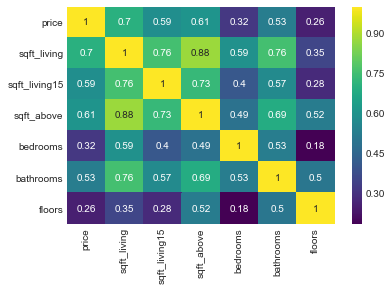

In [2]:
# First we make a new dataframe that of the pearson coefficient of each size variable and price against each other.
correlation_matrix = df[['price','sqft_living', 'sqft_living15','sqft_above', 'bedrooms', 'bathrooms','floors']].corr(method='pearson')
# Then we use seaboard's heatmap to display this information
sns.heatmap(correlation_matrix, cmap='viridis', annot=True)

The size metric which has the strongest correlation with price is the square footage of the living space, with a **Pearson Coefficient** of over 0.7. At a glance we can also see that `sqft_living` and `sqft_above` correlate very strongly with each other, meaning we won't be able to use both features in a multivariate regression without the danger of multicolinearity. 

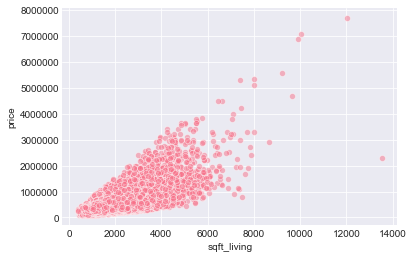

In [3]:
sns.scatterplot(df.sqft_living, df.price, alpha = 0.5)
plt.savefig('sqftvsprice.png')

#### The search for extra feature: Avoiding Multicollinearity

If we want to see which second feature will fit well into our model we can't just look at the Pearson Coefficient between those two features, there is more to look at. This is where a **Pair Plot** will come in handy in order to find a good predictor while avoiding multicollinearity. In the set of graphs below we can see a very distinctive straight line between `sqft_living` and `sqft_above`. This makes sense as you woudl assume most houses with more than one floor would have the same size for each floor.

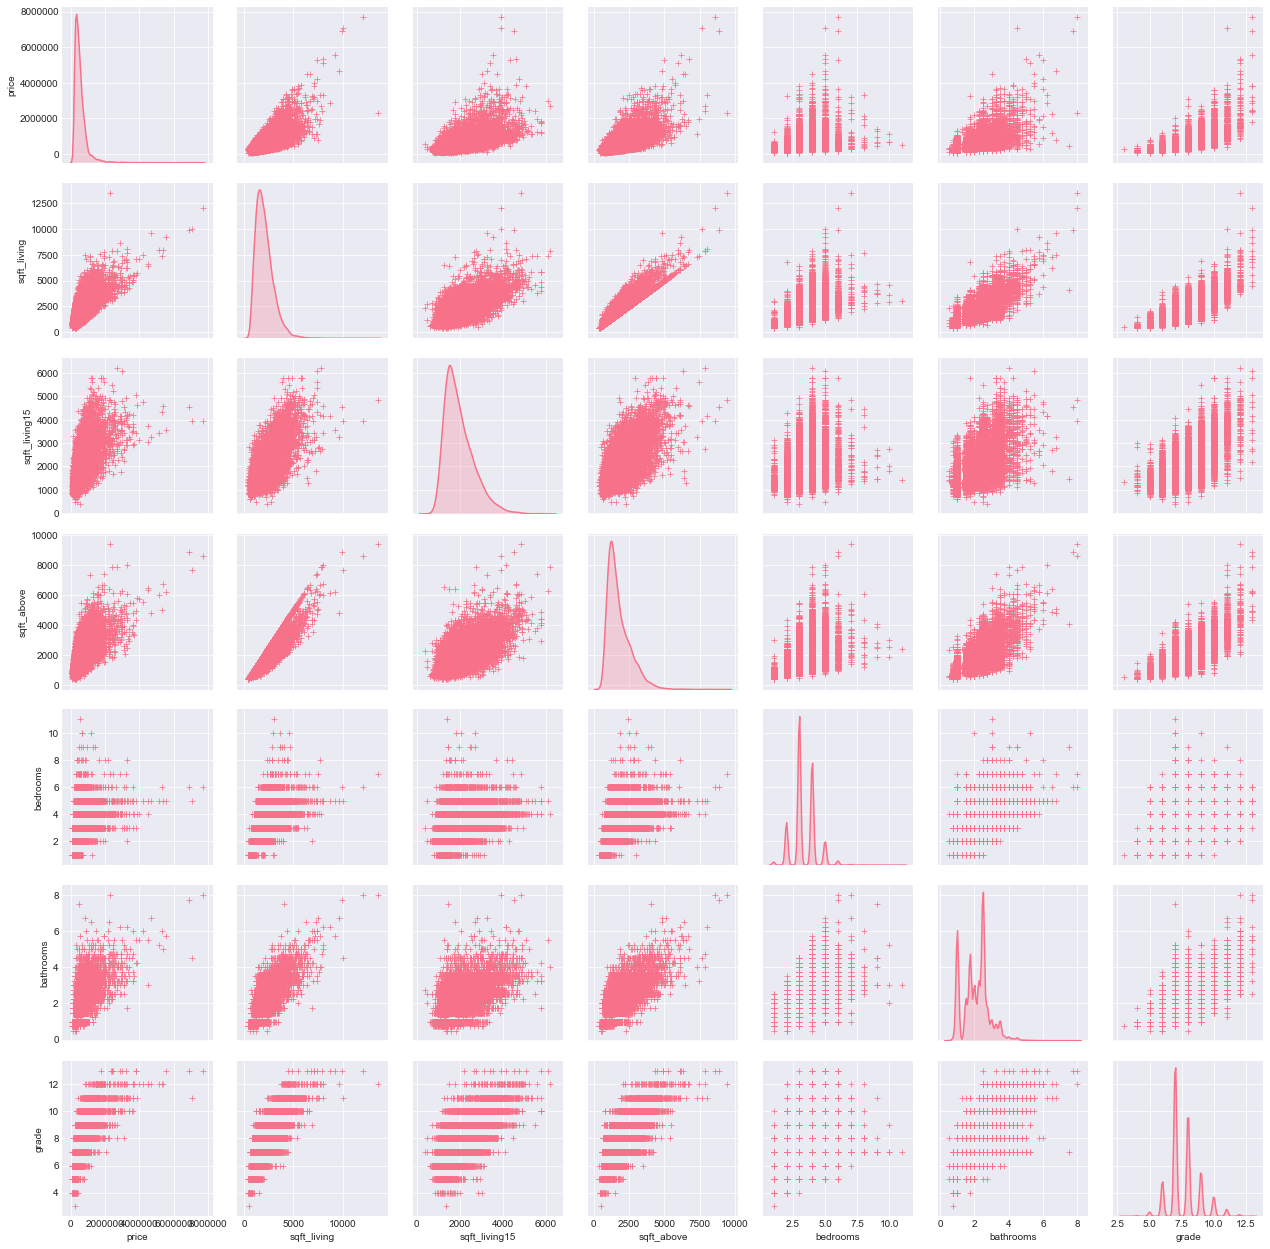

In [4]:
size_df = df[['price','sqft_living', 'sqft_living15','sqft_above', 'bedrooms', 'bathrooms', 'grade']]
sns.pairplot(size_df, diag_kind="kde", markers="+")

We want a second feature that correlates strongly with `price` and adds information while it doesn't have the potential issue of multicollinearity with `sqft_living`. The most obvious candidate for this is the `sqft_living15` or the square footage of the nearest fifteen properties, which has both of these desired properties. We will also choose `grade`, `floors` and add a dummy variable for the presence or not of basement (`0`:no basement, `1`: there is basement) without taking the size into consideration. 

Our rationale to choose `sqft_living15` is not just based on the correlation with price but also the understanding that the surroundings of the house will determine and add or remove value to the house price. For instance, a house surrounded by smaller houses could indicate that it is a lower income area, these areas would tend to be cheaper than a house surrounded by mansions even though your sqft is smaller in comparison. 


### Distribution charts:

Our continuous variables ( `price`, `sqft_living` and `sqft_living15`) present a very positively skewed distribution. As we discussed above, as price and square footage are both large units and are difficult to compare in scale, taking the log at this point will normalise these two variables and improve the normality of model itself.

Text(0.5, 1.0, 'sqft_living15 distribution')

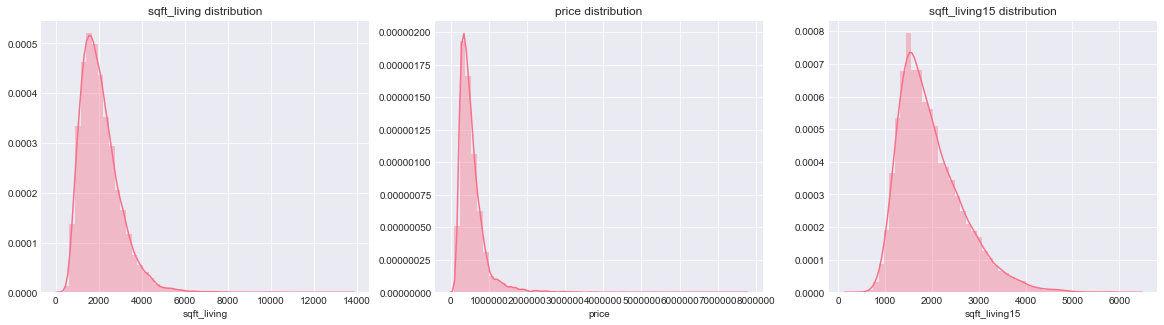

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

sns.distplot(df.sqft_living, ax=ax1).set_title('sqft_living distribution')
sns.distplot(df.price, ax=ax2).set_title('price distribution')
sns.distplot(df.sqft_living15, ax=ax3).set_title('sqft_living15 distribution')
#plt.savefig('sqftvsprice.png')


#### Log Time!

Lets look at the distribution before and after applying a logarithm to these variables.

Text(0.5, 1.0, 'Square Footage of Living Space')

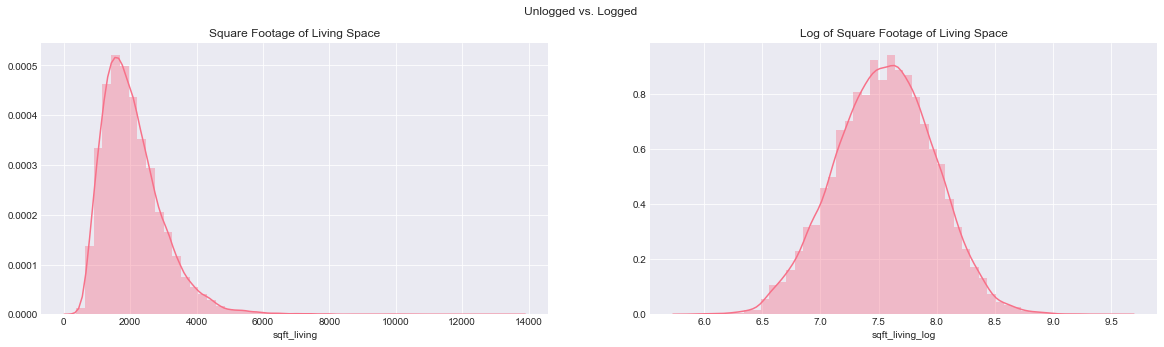

In [6]:
df['sqft_living_log'] = df['sqft_living'].map(lambda x: np.log(x)) #This logs all of the values for the square foot of living space.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.distplot(df['sqft_living_log'], ax=ax2).set_title('Log of Square Footage of Living Space')
plt.suptitle('Unlogged vs. Logged')
sns.distplot(df['sqft_living'], ax=ax1).set_title('Square Footage of Living Space')

The data for square footage of living space on its own has a strong positive skew. After applying a logarithm we see that the data is far more normally distributed. Now let's log the rest of the variables that we're going to be using: `price` and `sqft_living15`.

### Setting the variables

We will now create the dummy variable and log the remainder variables.

In [7]:
df['price_log'] = size_df['price'].map(lambda x: np.log(x))
df['sqft_living15_log'] = size_df['sqft_living15'].map(lambda x: np.log(x))

In [8]:
df.replace({'sqft_basement': '?'}, {'sqft_basement': 0}, inplace=True)

In [9]:
df['sqft_basement'] = df['sqft_basement'].map(lambda x: float(x))

In [10]:
df['sqft_basement_dummy'] = df['sqft_basement'].map(lambda x: 1 if x> 0 else 0)

## Model 1: sample data

First we will make a model using our selected parameters and assess its robustness with 80% of the dataset. We will then evaluate the results and apply it to the full dataset. 

In [11]:
df_sample = df.iloc[0:17276,:]
print(df_sample.shape)

(17276, 26)


In [12]:
y2 = df_sample['price_log']
X2 = df_sample.loc[:,['grade', 'sqft_living_log', 'sqft_basement_dummy', 'sqft_living15_log', 'floors' ]]

In [13]:
X2 = sm.add_constant(X2) #x is sqft_living
model_sm = sm.OLS(y2,X2)

# Actually LEARNING
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))

R2 = 0.56
const                  7.7446
grade                  0.1890
sqft_living_log        0.2348
sqft_basement_dummy    0.1498
sqft_living15_log      0.2603
floors                 0.0444
dtype: float64


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     4369.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:22:32   Log-Likelihood:                -6452.6
No. Observations:               17276   AIC:                         1.292e+04
Df Residuals:                   17270   BIC:                         1.296e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.7446      0.078     99.127      0.000       7.592       7.898
grade                   0.1890      0.004     49.238      0.000       0.181       0.197
sqft_living_log         0.2348      0.012     19.740      0.000       0.211       0.258
sqft_basement_dummy     0.1498      0.006     23.446      0.000       0.137       0.162
sqft_living15_log       0.2603      0.013     19.568      0.000       0.234       0.286
floors                  0.0444      0.007      6.796      0.000       0.032       0.057
==============================================================================
Omnibus:                       47.814   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.660
Skew:                           0.121   Prob(JB):                     4.47e-11
Kurtosis:                       2.911   Cond. No.                         390.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above we have coefficients for each of the features of the dataset, and because they are logs they represent percentage change. As well as a constant percentage increase of 7.6614. Below we'll make a qq-plot of our residuals to see how normally they are distributed.

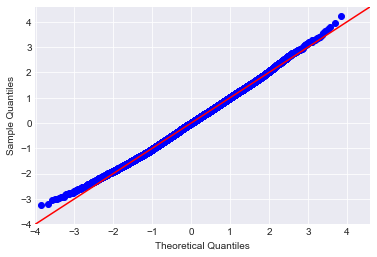

In [15]:
residuals = results.resid
fig = sm.qqplot(residuals, line='45', fit=True)
plt.show()

At either end of the quartiles, our residuals start to part with our normality line, but given the levels of kurtosis and skewness we are satisfied with the normallity results. We would also like to improve on our r-squared of 0.55 but adding extra variables generates multicolinearity while the r-squared only add marginal value, so we have decided to keep this result and apply it to the population.

## Final Model

In [16]:
y = df['price_log']
X = df.loc[:,['grade', 'sqft_living_log', 'sqft_basement_dummy', 'sqft_living15_log', 'floors' ]]

In [17]:
X = sm.add_constant(X) #x is sqft_living
model_sm = sm.OLS(y,X)

# Actually LEARNING
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))
y_est = results.fittedvalues
# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))


R2 = 0.57
const                  7.8729
grade                  0.1954
sqft_living_log        0.2546
sqft_basement_dummy    0.1502
sqft_living15_log      0.2189
floors                 0.0323
dtype: float64



Our regression on the full populaiton improves r-squared and remains free of multicollinearity. Our residuals meet kurtosis and skewness desirable levels, therefore it satisfies normality.

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     5648.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:22:32   Log-Likelihood:                -7760.2
No. Observations:               21596   AIC:                         1.553e+04
Df Residuals:                   21590   BIC:                         1.558e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.8729      0.066    120.192      0.000       7.744       8.001
grade                   0.1954      0.003     58.877      0.000       0.189       0.202
sqft_living_log         0.2546      0.010     24.929      0.000       0.235       0.275
sqft_basement_dummy     0.1502      0.005     27.446      0.000       0.139       0.161
sqft_living15_log       0.2189      0.012     18.916      0.000       0.196       0.242
floors                  0.0323      0.005      6.102      0.000       0.022       0.043
==============================================================================
Omnibus:                       72.012   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.676
Skew:                           0.141   Prob(JB):                     1.65e-16
Kurtosis:                       2.966   Cond. No.                         372.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

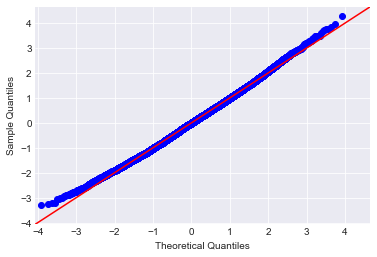

In [19]:
residuals = results.resid
fig = sm.qqplot(residuals, line='45', fit=True)
plt.show()

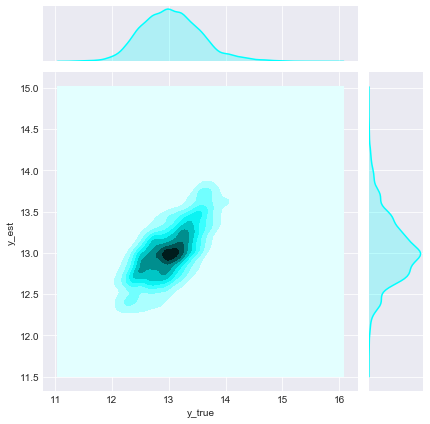

In [20]:
estimation = pd.DataFrame(dict(y_est = y_est, y_true = y)).reset_index()
estimation.describe()


sns.jointplot(x=estimation.y_true, y=estimation.y_est, data=estimation, kind="kde", color='cyan')

The jointplot above remarks where our estimated values and real price values meet, as we can observe, there is a large concentration in the middle of the distribution.

## Log interpretation:
    
We have taken logs in our target and independent variables and therefore further analysis is needed in order to interpret properly our results. We will use `sqft_living` and `floors` to represent how the values would be calculated.

For a 10% increase in sqft of living, all other variables remaining equal (or unchanged) we would expect the price to increase by 2.5% where 1.1 is the 10% increase (1+0.1) and exp 0.25 is our beta resutl, then we extract 1 and multiply by 100 in order to get the percentage change [(((1.1^0.25)-1)*100]
 
Our floor variable, implies that one unit increase (i.e one extra floor) will translate in average into a 3% price increase (exp(0.0323)) where 0.0323 is the beta value

Some Math:

log(price(n2))–log(price(n1))=β*[log(sqft2)–log(sqft1)]

log(price(n2)/log(price(n1) = β*[log(sqft2/sqft1)]

price(n2)/price(n1) = (sqft2/sqft1)^β


In [21]:
def predictor(grade, sqft_living, sqft_basement_dummy, sqft_living15, floors):
    logged_price = 7.8729 + (grade*0.1954) + (np.log(sqft_living)*0.2546) + (sqft_basement_dummy*0.1502) + (np.log(sqft_living15)*0.2189) + (floors*0.0323)
    return round(np.exp(logged_price))

In [22]:
predictor(7,2100,0,1640,2)

389769.0

## Question 2 - Exploratory Data Analysis and Visualisation

While continuous data is king, categorical data brings its own charms. Consideration of the categorical data in the set allows us to ask pertinent questions such as whether it is worth improving the condition or grade of your house before selling it. 

#### Condition

Looking at the [King County Assessment Roll](https://www.kingcounty.gov/depts/assessor/~/media/depts/Assessor/documents/AreaReports/2018/Residential/015.ashx) (p. 30) gives us a rundown of how condition and grade are assessed.

Condition:

1. Poor - Many repairs needed. Showing serious deterioration.
2. Fair - Some repairs needed immediately. Much deferred maintenance.
3. Average - Depending upon age of improvement; normal amount of upkeep for the age of the home.
4. Good - Condition above the norm for the age of the home. Indicates extra attention and care has been taken to maintain.
5. Very Good - Excellent maintenance and updating on home. Not a total renovation.


Although this doesn't give us a surfeit of information, we can at least guess that the difference between a condition of 1 and 2 are probably smaller than conditions 2 and 3. If this is so then we would expect to see a larger jump in price between conditions 2 and 3. If we can tell how much these jumps in prices are then we can give people an idea of whether it is worth making the necessary renovation to their houses. 


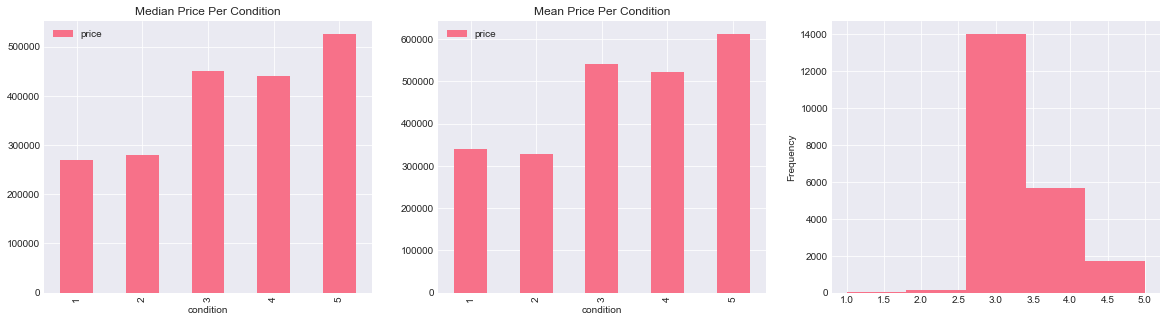

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

condition_median = df.groupby('condition').median()
condition_mean = df.groupby('condition').mean()

condition_median.plot.bar(y='price', ax=ax1).set_title('Median Price Per Condition')
condition_mean.plot.bar(y='price', ax=ax2).set_title('Mean Price Per Condition')
df.condition.plot.hist(ax=ax3, bins=5)
plt.savefig('conditionimprovement')

The jump in mean and median price between conditions 2 or 3 is quite considerable. However we've included a second third plot examining the distributions of these grades, which will serve as a cautionary tale about the nature as to how much we can trust our averages. For example although both average prices for condition 3 are higher, there is far more price data for condition 3 than any other condition. This does let us make the observation that the 'default' value for condition ratings in King County appears to be 3. If you do happen to find yourself in the unfortunate position of having a house in 2 condition then it seems fairly likely that renovation would be worthwhile.

#### Grade
Now let's take a look at the grading system:

1-3. Falls short of minimum building standards. Normally cabin or inferior structure.
4. Generally older low quality construction. Does not meet code.
5. Lower construction costs and workmanship. Small, simple design.
6. Lowest grade currently meeting building codes. Low quality materials, simple designs.
7. Average grade of construction and design. Commonly seen in plats and older subdivisions.
8. Just above average in construction and design. Usually better materials in both the exterior and interior finishes.
9. Better architectural design, with extra exterior and interior design and quality.
10. Homes of this quality generally have high quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.
11. Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures and more luxurious options.
12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
13. Generally custom designed and built. Approaching the Mansion level. Large amount of highest quality cabinet work, wood trim and marble; large entries.

Looking at the grading system we see a number of limitations, for example it seems impossible for a small apartment to have a grading of 13. Nonetheless we can get a good understanding of whether it is worth it to get the necessary renovations to get that jump in grading.

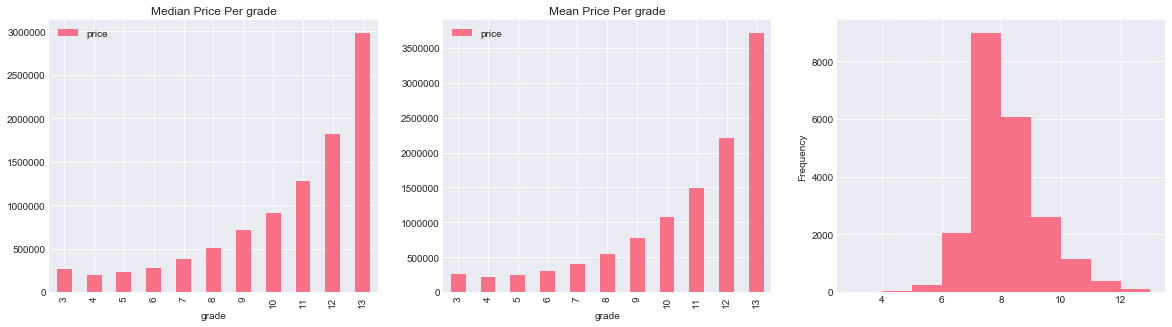

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

grade_median = df.groupby('grade').median()
grade_mean = df.groupby('grade').mean()

grade_median.plot.bar(y='price', ax=ax1).set_title('Median Price Per grade')
grade_mean.plot.bar(y='price', ax=ax2).set_title('Mean Price Per grade')
df.grade.plot.hist(ax=ax3)

We can see that a majority of properties have a grading of 7, and so the most obvious question is whether its worth the renovations to get from the 7 group to the 8 group, which seems like a possible improvement for most of these properties.

In [25]:
median_gain = grade_median['price'].loc[8] - grade_median['price'].loc[7] #Median Price Difference
mean_gain = grade_mean['price'].loc[8] - grade_mean['price'].loc[7] #Mean Price Difference

print('The median price gain between grades 7 and 8 is {} and the mean price gain is {}'.format(median_gain, round(mean_gain)))

The median price gain between grades 7 and 8 is 135000.0 and the mean price gain is 140419.0


In [26]:
mean_gain_p_sqft = mean_gain/grade_mean['sqft_living'].loc[7] #A rough estimate for the difference in price per square footage.

In [27]:
1500 * mean_gain_p_sqft #Trying this with a very common square footage

124667.17972001088

In [28]:
df.loc[(df['grade'] == 7) & (df['sqft_living'] ==1500)].describe().round() # Looking for the mean price for this exact square footage and grade 7

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_log,price_log,sqft_living15_log,sqft_basement_dummy
count,77.0,7.700000e+01,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,...,63.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0
mean,10851.0,4.387379e+09,377334.0,3.0,2.0,1500.0,7250.0,1.0,0.0,0.0,...,0.0,98076.0,48.0,-122.0,1578.0,7276.0,7.0,13.0,7.0,0.0
std,5985.0,2.572858e+09,135713.0,1.0,1.0,0.0,3745.0,1.0,0.0,0.0,...,0.0,52.0,0.0,0.0,243.0,3852.0,0.0,0.0,0.0,0.0
min,689.0,1.045010e+08,182568.0,2.0,1.0,1500.0,1119.0,1.0,0.0,0.0,...,0.0,98001.0,47.0,-122.0,980.0,1057.0,7.0,12.0,7.0,0.0
25%,7072.0,2.473101e+09,270000.0,3.0,2.0,1500.0,4158.0,1.0,0.0,0.0,...,0.0,98031.0,47.0,-122.0,1480.0,4500.0,7.0,13.0,7.0,0.0
50%,11049.0,4.427100e+09,352500.0,3.0,2.0,1500.0,7200.0,1.0,0.0,0.0,...,0.0,98058.0,48.0,-122.0,1500.0,7272.0,7.0,13.0,7.0,0.0
75%,16281.0,6.648000e+09,435000.0,3.0,2.0,1500.0,9656.0,2.0,0.0,0.0,...,0.0,98117.0,48.0,-122.0,1700.0,8374.0,7.0,13.0,7.0,1.0
max,21346.0,9.307300e+09,782000.0,5.0,4.0,1500.0,19113.0,3.0,0.0,2.0,...,0.0,98199.0,48.0,-122.0,2700.0,20800.0,7.0,14.0,8.0,1.0


In [29]:
df.loc[(df['grade'] == 8) & (df['sqft_living'] ==1500)].describe().round() # Looking for the mean price for this exact square footage and grade 8

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_log,price_log,sqft_living15_log,sqft_basement_dummy
count,18.0,1.800000e+01,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,16.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
mean,14013.0,3.731851e+09,468997.0,3.0,2.0,1500.0,4931.0,2.0,0.0,0.0,...,0.0,98099.0,48.0,-122.0,1718.0,4442.0,7.0,13.0,7.0,0.0
std,6670.0,2.613038e+09,156640.0,0.0,1.0,0.0,4576.0,1.0,0.0,1.0,...,0.0,45.0,0.0,0.0,275.0,2922.0,0.0,0.0,0.0,1.0
min,867.0,4.000047e+07,170000.0,2.0,1.0,1500.0,761.0,1.0,0.0,0.0,...,0.0,98023.0,47.0,-122.0,1360.0,1282.0,7.0,12.0,7.0,0.0
25%,11202.0,1.972202e+09,410500.0,2.0,2.0,1500.0,1344.0,1.0,0.0,0.0,...,0.0,98095.0,48.0,-122.0,1500.0,1612.0,7.0,13.0,7.0,0.0
50%,15579.0,2.767952e+09,482250.0,3.0,2.0,1500.0,3804.0,2.0,0.0,0.0,...,0.0,98107.0,48.0,-122.0,1710.0,4204.0,7.0,13.0,7.0,0.0
75%,19533.0,5.046888e+09,525000.0,3.0,2.0,1500.0,7392.0,2.0,0.0,0.0,...,0.0,98121.0,48.0,-122.0,1935.0,7193.0,7.0,13.0,8.0,1.0
max,21566.0,9.126100e+09,765000.0,3.0,4.0,1500.0,18540.0,3.0,0.0,3.0,...,0.0,98177.0,48.0,-122.0,2380.0,9500.0,7.0,14.0,8.0,1.0


In [30]:
468997 - 377334 # Price difference for 1500 sqft between grades 7 & 8

91663

If you can get your renovation at anywhere under this cost per square foot it seems fairly likely that it would be worth it to go ahead! There are obvious caveats, as our model above shows house prices vary on much more than just square footage, but hopefully this gives some idea of the jump in prices between conditions and grades. 

## Question 3 - Exploratory Data Analysis and Visualisation

Our third question is somewhat similar to our last question. We were in part inspired by the television 'Stay or Sell' in which a homeowner is given two options for improving their living circumstances; they can either renovate the house they already live in, or move to a new house. Our question is slightly different, it instead looks at how recently a house was renovated and asks whether it is best to stay in your newly renovated home, or whether the improvements in your house have improved its value enough for you to trade up to a new house. 

Firstly as we explained in our **Data Cleaning** section, we had to reformat our `date` column in order to get it to play ball. We then make a subsection of the houses that have actually been renovated and then subtract the year renovated from the date sold in order to see how long before the sale the house was renovated. We'll show how we did this below. 

In [31]:
renovated_df = df[df['yr_renovated']>0] 
renovated_df = renovated_df.dropna(subset=['yr_renovated'], axis=0) # Making ourselves a subset of renovated properties

renovated_df['date'] = renovated_df['date'].map(lambda x: dt.datetime.strptime(str(x),'%m/%d/%Y').strftime('%d/%m/%Y')) # Converting to a more manageable time format.
years_sold = [float(x[6:11]) for x in renovated_df.date] #Targeting just the year from the date string
years_renovated = [x for x in renovated_df.yr_renovated] # Getting the years renovated

sold_array = np.array(years_sold) # Making arrays
renovated_array = np.array(years_renovated)

years_ago = sold_array - renovated_array

renovated_df['renovated_yrs_ago'] = years_ago

renovated_df['renovated_yrs_ago'].value_counts()# Having a look at the value counts. 

0.0     68
1.0     37
8.0     34
10.0    29
11.0    27
15.0    23
7.0     21
12.0    21
14.0    21
31.0    20
25.0    20
9.0     19
24.0    19
5.0     18
26.0    18
13.0    16
6.0     16
16.0    16
20.0    15
28.0    15
29.0    15
23.0    14
21.0    14
22.0    13
2.0     13
4.0     13
17.0    12
19.0    12
32.0    11
27.0    10
        ..
45.0     5
51.0     4
33.0     4
41.0     4
40.0     4
38.0     4
59.0     4
58.0     3
69.0     3
56.0     3
52.0     3
42.0     3
36.0     3
47.0     3
74.0     2
43.0     2
70.0     2
54.0     2
39.0     2
49.0     2
55.0     2
48.0     1
65.0     1
57.0     1
60.0     1
53.0     1
64.0     1
66.0     1
80.0     1
61.0     1
Name: renovated_yrs_ago, Length: 70, dtype: int64

Now that we have groups based on how long ago properties were renovated, let's visualise the average price for each of these year groups as well as their min and max values to see if we can spot any salient trend. 

In [32]:
mean_renovated = renovated_df.groupby('renovated_yrs_ago').mean()
mean_renovated.round().head()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_log,price_log,sqft_living15_log,sqft_basement_dummy
renovated_yrs_ago,,,,,,,,,,,,,,,,,,,,,
-1.0,11675.0,6.874167e+09,637667.0,4.0,3.0,3183.0,14424.0,1.0,0.0,2.0,...,2015.0,98148.0,48.0,-122.0,2362.0,12066.0,8.0,13.0,8.0,1.0
0.0,8734.0,4.480442e+09,676600.0,4.0,2.0,2200.0,7427.0,1.0,0.0,0.0,...,2014.0,98107.0,48.0,-122.0,1818.0,7159.0,8.0,13.0,7.0,1.0
1.0,10534.0,5.430533e+09,629492.0,4.0,2.0,2018.0,7681.0,1.0,0.0,0.0,...,2013.0,98111.0,48.0,-122.0,1686.0,6904.0,8.0,13.0,7.0,1.0
2.0,10099.0,2.488872e+09,804331.0,3.0,2.0,1966.0,7632.0,1.0,0.0,1.0,...,2013.0,98094.0,48.0,-122.0,1850.0,9303.0,7.0,13.0,7.0,0.0
3.0,9149.0,3.783135e+09,542083.0,3.0,2.0,1632.0,4102.0,1.0,0.0,0.0,...,2011.0,98105.0,48.0,-122.0,1484.0,4433.0,7.0,13.0,7.0,1.0


Let's now look at the average price per square foot of these properties based on how long ago they were renovated, as well as the minimum and maximum values for these years.

In [41]:
renovated_df['ppsqft'] = renovated_df['price']/renovated_df['sqft_living']

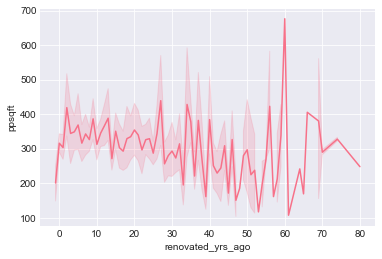

In [42]:
sns.lineplot(x=renovated_df.renovated_yrs_ago, y=renovated_df.ppsqft)

The strong line in the middle is the mean of the data and the lighter areas above and below are their minimum and maximum values. Although there seems to be a slight trend for recently renovated properties to be more expensive, there is not a strong enough trend and probably not enough data to conclude that this is definitely a realiable predictor for price. The data also becomes more eratic as the longer ago properties were renovated, showing how there is less information available about properties that were renovated a long time ago. More information about older renovations would give us greater insight in this regard.

## Conclusions

We feel confident that between our exploratory analysis and our modelling we are able to make the following conclusions:
- Square footage of the living space is the most effective determinant of price for a given house, however in combination with other features of the house, a more nuanced price estimation is possible
- Rennovation from conditions 2 to 3 accompanies a considerable increase in price per square footage. Although such a renovation may entail serious costs, it seems highly likely that the increase in potential price will be worth the renovation in certain cases. 
- Similarly improvement from the average grade 7 to the next grade 8 accompanies a considerable increase in price per square footage. Both of these observations would be consolidated by an estimate for renovation costs, which is data we have not been able to find. 
- How recently a property was renovated is not as effective in estimating price as more traditional metrics such as size and condition, so if you've recently renovated your house and you like the renovation then you might as well stay!